## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Project review date/time: Monday 1 April 2019 11am ET
* Instructor name: Jeff Herman
* Blog post URL:


"Database for The Scratched Voices Begging to be Heard: The Graffiti of Pompeii and Today"

by Alexa Rose

https://core.tdar.org/dataset/445837/database-for-the-scratched-voices-begging-to-be-heard-the-graffiti-of-pompeii-and-today

To do:

- Big pictrue explanation
- GraphViz?
- SeaBorn confusion matrix
- Write up final model for log reg
- Examples of each new category to illustrate



<a id = 'top'></a>

# Contents
- Libraries
- [A first look at the data](#obtain)
- [Cleaning the raw data](#scrub)
- [Exploratory data analysis](#explore)
 - [Character count and imperatives](#character_imperative)
 - [How good are the categories?](#prelim_model)
 - [Detour: improving the categories](#detour_cat)
- Modeling
 - [Model #1: Logistic Regression](#model1)
   - [intercept] 
   - [Adjusting regularization parameter](#logreg_regparam)
   - [Cross validation](#logreg_cv)
   - [The final model](#logreg_final)
 - [Model #2: Decision tree](#model2)
   - [Tuning Hyperparameters](#tree_tuning_hypers)
   - [Tuning with Grid Search CV](#tree_grid_search)
   - [The final model](#tree_final)
 - [Model #3: Random forest](#model3)
   - [Something]
   - [Something]
   - [The final model](#forest_final)
- [Conclusions](#concl)

# Libraries

In [1]:
import graffiti_functions #Import my custom functions
from graffiti_functions import plot_conf_matrix, keyword_matrix, write, hyper, compare_hypers, plot_hypers, draw_graph 
import pandas as pd #For working with DataFrames
import matplotlib.pyplot as plt #For visualizing plots
import numpy as np #For mathematical operations
import random                   #for generating random numbers for train/test split
import copy                     #for making deep copies of mutable objects
import time                     #for timing expensive operations
from pandasql import sqldf #for manipulating DataFrames with SQL style queries

#############################
# PREPARING DATA FOR MODELING:
#To divide data when testing a trained model
from sklearn.model_selection import train_test_split 
#For scaling/normalizing, and for LabelEncoder and OneHotEncoder
from sklearn import preprocessing
#To turn categorical columns into sets of numerical columns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#####################
# LOGISTIC REGRESSION:
#To build regular logistic regression models
from sklearn.linear_model import LogisticRegression
#To build LRs with cross validation
from sklearn.linear_model import LogisticRegressionCV

################
# DECISION TREES:
#For building decision trees
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
#To find best combination of hyperparameters in decision trees
from sklearn.model_selection import GridSearchCV
#To evaluate accuracy of decision trees
from sklearn.model_selection import cross_val_score

##################
# RANDOM FORESTS:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

###################
# ASSESSING MODELS:
#To assess accuracy of logistic regression or decision trees
from sklearn.metrics import confusion_matrix 
#To iteratively append labels to cells in a confusion matrix
import itertools 
#To get accuracy, precision, recall, and F1 score (weighted accuracy) of a given confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#To view the accuracy metrics for a given confusion matrix
from sklearn.metrics import classification_report

In [ ]:
#Thing for separating values by hyphen slash etc



In [ ]:
#Thing for getting indexes and filling values maybe



<a id = 'obtain'></a>

[(Back to top)](#top)

# A first look at the data

In [2]:
#Obtain the raw data
df_raw = pd.read_csv('graffiti.csv')

In [ ]:
df_raw.head(20)

In [ ]:
df_raw.info()

Columns to drop:

'found'
'org'?
'comments'?

Change 'Literacy' to integer before categorizing. Rename column.

Rename 'Image ' as 'Image'.

Categorical variables to transform: Reggio, Insula, Literacy, Context type specific, Context type general, Famous House (?), Socio-economic status


Null values to fill: Reggio, Insula, Entrance, Context type specific, Context type general, Famous House,

Target: 'Category'

<a id = 'scrub'></a>

[(Back to top)](#top)

# Cleaning the data

## Column by column

### 'CIL IV Pound sign'

In [3]:
df_raw['CIL IV #'] = df_raw['CIL IV #'].fillna(0)

### 'Reggio'

In [ ]:
df_raw['Reggio'].value_counts()

In [ ]:
print(df_raw['Reggio'].isna().sum())

In [4]:
#Fill NaN values
df_raw['Reggio'] = df_raw['Reggio'].fillna(0)
#Change 6_7 to 6
df_raw.at[994, 'Reggio'] = '6'
#Change data type to integer
df_raw['Reggio'] = df_raw['Reggio'].astype('float').astype('int')

Zero values can be filled later once more is known about the reggios.

### 'Insula'

In [ ]:
df_raw['Insula'].value_counts()

In [ ]:
df_raw['Insula'].isna().sum()

In [5]:
#Fill null values
df_raw['Insula'] = df_raw['Insula'].fillna(0)

#Replace the values with underscores
df_raw.at[985, 'Insula'] = '4'
df_raw.at[986, 'Insula'] = '4'
df_raw.at[983, 'Insula'] = '4'
df_raw.at[984, 'Insula'] = '4'
df_raw.at[988, 'Insula'] = '9'
df_raw.at[987, 'Insula'] = '8'
df_raw.at[982, 'Insula'] = '12'
df_raw.at[981, 'Insula'] = '1'

#Change data type to intger
df_raw['Insula'] = df_raw['Insula'].astype('float').astype('int')

### 'Entrance'

In [ ]:
df_raw['Entrance'].value_counts()

In [6]:
#Fill null values
df_raw['Entrance'] = df_raw['Entrance'].fillna('unknown')

#Replace all values with underscores or hyphens
#Dict to fill values from 'Entrance'
entrance_replacements = dict()
entrance_values = df_raw['Entrance'].value_counts()

#Iterate over Entrance values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in entrance_values.index:
        if '_' in index:
            index_split = index.split('_')
            entrance_replacements[index] = index_split[0]
        elif '-' in index:
            index_split = index.split('-')
            entrance_replacements[index] = index_split[0]
            
df_raw['Entrance'] = df_raw['Entrance'].replace(entrance_replacements)

#Change 'F' to 'f'
df_raw.at[661, 'Entrance'] = df_raw.at[661, 'Entrance'].lower()
#Change '4/5/' to '4'
df_raw.at[6, 'Entrance'] = '4'
#Replace 'I' and '?'
df_raw['Entrance'] = df_raw['Entrance'].replace({'I': 'i', '?': 'unknown'})

This is better, but it may have to be categorized.

### 'found?'

In [ ]:
df_raw['found?'].isna().sum()

In [7]:
#Can just be dropped
df_raw.drop(['found?'], axis = 1, inplace = True)

### 'In English'

In [ ]:
df_raw['In English'].isna().sum()

In [8]:
#Fill nulls so that they can be read
df_raw['In English'] = df_raw['In English'].fillna('')

#Rows with null values or unhelpful 'CHECK' values
blank_indexes = df_raw.index[df_raw['In English'] == '']
check_indexes = df_raw.index[df_raw['In English'] == '[CHECK]']

#Drop the empty rows. They aren't useful if they don't have the English text of the graffiti.
df_raw.drop(blank_indexes, inplace = True)
df_raw.drop(check_indexes, inplace = True)

### 'org. '

In [ ]:
df_raw['org. '].value_counts()[:10]

In [9]:
#Won't be useful here. Can be dropped.
df_raw.drop(['org. '], axis = 1, inplace = True)

### 'Literacy'

In [ ]:
df_raw['Literacy (1-3)'].value_counts()

In [ ]:
df_raw['Literacy (1-3)'].isna().sum()

In [10]:
#Rename column
df_raw = df_raw.rename(index=str, columns = {'Literacy (1-3)': 'Literacy'})

#Turn the few 1 values into 2s.
df_raw['Literacy'] = df_raw['Literacy'].replace({1.0: 2})

#Fill nulls
df_raw['Literacy'] = df_raw['Literacy'].fillna(2)

#Turn floats into integers
df_raw['Literacy'] = df_raw['Literacy'].astype('float').astype('int')

### 'In org. language'

In [ ]:
df_raw['In org. language'].value_counts().sum()

In [11]:
#Dropping for now
df_raw.drop(['In org. language'], axis = 1, inplace = True)

Not sure what to do with this at this point.

### 'Context type general'

In [ ]:
df_raw['Context type general'].value_counts()

In [ ]:
df_raw['Context type general'].isna().sum()

In [12]:
# No specific, no general, no reggio, insula
no_spec_no_gen = df_raw[df_raw['Context type specific'].isna() & df_raw['Context type general'].isna()]

no_spec_no_gen[(no_spec_no_gen['Reggio'] == 0) & (no_spec_no_gen['Insula'] == 0)].shape

#Must drop the 43 rows that don't have a reggio, insula, specfic context or general context
to_drop = no_spec_no_gen[(no_spec_no_gen['Reggio'] == 0) & (no_spec_no_gen['Insula'] == 0)]
df_raw.drop(to_drop.index, axis = 0, inplace = True)

#Maybe famous house can fill in for general context where it's missing?
famoushouse_nogen = df_raw[
    (df_raw['Famous House'].notna())
    & 
    (df_raw['Context type general'].isna())]

#Get indexes of all rows without a gen context but with a famous house
indexes = famoushouse_nogen.index

famoushouse_gencontexts = {
    'Praedia ': 'building',
    'Basilica': 'basilica',
    'House of': 'house',
    'house of': 'house',
    'Villa of': 'house',
    'Building': 'building',
    'near the Porta Vesuvio': 'necropolis',
    'Workshop': 'workshop'
}

#Replace gen context with the building type from its famous house
#Iterate over all the rows which have a famous house but lack a gen context
for index in indexes:
    #Iterate over the keys of famous houses
    for key, val in famoushouse_gencontexts.items():
        #If the row's famous house matches one from the dict
        if key in df_raw.at[index, 'Famous House']:
            #Fill missing gen context value with value from dict
            df_raw.at[index, 'Context type general'] = val
            
#Noticed that Bar of Sotericus has gen context of "house"
indexes = df_raw[df_raw['Famous House'] == 'Bar of Sotericus']['Context type general']
#Replace 'house' with 'bar' for these
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'bar'
    
#Noticed that 'Outside Porta Marina' had two NaN gen contexts to fix
#Will drop these because they're missing too many columns
df_raw.drop(['997', '998'], axis = 0, inplace = True)

#change all building types for spec context "workshop" to gen context "workshop"
indexes = df_raw[df_raw['Context type specific'] == 'workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Same for 'Workshop'
indexes = df_raw[df_raw['Context type specific'] == 'Workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Specific context "dining room" to general context "house"
indexes = df_raw[
    (df_raw['Context type specific'] == 'dining room')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'

#Spec context "shop" to general context "shop"
indexes = df_raw[
    (df_raw['Context type specific'] == 'shop')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'shop'
    
#Spec context "kitchen" to general context "house"    
indexes = df_raw[
    (df_raw['Context type specific'] == 'kitchen')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'    
    
#Add consistency to a few of the values
replacements = {'Baths': 'baths',
                'unit': 'apartment'}
df_raw['Context type general'] = df_raw['Context type general'].replace(replacements)

#Fill null values
df_raw['Context type general'] = df_raw['Context type general'].fillna('unknown')

#Changing the name of the column
df_raw = df_raw.rename(index=str, columns ={
              'Context type general': 'Building Type'})

### 'Context type specific'

In [ ]:
df_raw['Context type specific'].value_counts()

In [13]:
#Add consistency to values
replacements = {'façade': 'facade',
                'tablinium': 'tablinum',
                'Workshop': 'workshop'
                }

df_raw['Context type specific'] = df_raw['Context type specific'].replace(replacements)

#Fill null values
df_raw['Context type specific'] = df_raw['Context type specific'].fillna('unknown')

#Rename column
df_raw = df_raw.rename(index=str, columns ={'Context type specific': 'Position'})

### 'Famous House'

In [ ]:
df_raw['Famous House'].value_counts()[60:90]

In [ ]:
df_raw['Famous House'].isna().sum()

In [14]:
#Turn this column into a 0/1 for no/yes
indexes = df_raw[df_raw['Famous House'].notna()]

for index in indexes.index:
    df_raw.at[index, 'Famous House'] = 1
    
df_raw['Famous House'] = df_raw['Famous House'].fillna(0)

df_raw['Famous House'] = df_raw['Famous House'].astype('int')

### Target: 'Category'

In [ ]:
df_raw['Category'].value_counts()

In [15]:
#Replace all values with back slashes
#Dict to fill values from 'Category'
cat_replacements = dict()
cat_values = df_raw['Category'].value_counts()

#Iterate over Category values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first value from each pair
for index in cat_values.index:
        if '/' in index:
            index_split = index.split('/')
            cat_replacements[index] = index_split[0]
            
df_raw['Category'] = df_raw['Category'].replace(cat_replacements)

#This creates one instance of 'Political' with a space
df_raw['Category'] = df_raw['Category'].replace({'Political ': 'Political'})

#Fill null values
df_raw['Category'] = df_raw['Category'].fillna('unknown')

### 'Written by'

In [ ]:
df_raw['Written by'].value_counts()

In [16]:
#Fill null values first so str.contains can be used
df_raw['Written by'] = df_raw['Written by'].fillna('unknown')

#Clean up instances of ovid
ovids = df_raw[df_raw['Written by'].str.contains('Ovid', regex = False, case = False)]
for index in ovids.index:
    df_raw.at[index, 'Written by'] = 'Ovid'

#Clean up instances of virgil    
virgils = df_raw[df_raw['Written by'].str.contains('rgil', regex = False, case = False)]
for index in virgils.index:
    df_raw.at[index, 'Written by'] = 'Virgil'

#People who look like real writers as taken from value_counts    
writers = ['Antheros', 'Ennius', 'Epaphra', 
           'Virgil', 'Horace', 'Homer', 
           'Herodotus', 'Lucretius', 'Menander',
           'Ovid', 'poem', 'Propertius',
           'Salvius', 'Senica', 'Tibutinus']
                
#Iterate over all rows to replace values with 1 for a writer
#or zero for no writer
for index in df_raw.index:
    if any(writer in df_raw.at[index, 'Written by'] for writer in writers):
        df_raw.at[index, 'Written by'] = 1
    else:
        df_raw.at[index, 'Written by'] = 0
        
#Change name of column to 'Writer'
df_raw = df_raw.rename(index=str, columns ={'Written by': 'Writer'})

### 'Work', 'Meter', and 'Reptition'

In [17]:
#Change 'Work' to 0/1 no/yes
indexes = df_raw[df_raw['Work'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Work'] = 1    
df_raw['Work'] = df_raw['Work'].fillna(0)


#Change meter to 0/1 no/yes  
indexes = df_raw[df_raw['Meter'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Meter'] = 1    
df_raw['Meter'] = df_raw['Meter'].fillna(0)  

#Smush together Writer Work and Meter
indexes = df_raw[(df_raw['Writer'] == 0)
        &
        (
            (df_raw['Work'] == 1) 
            | 
            (df_raw['Meter'] == 1)
        )]

for index in indexes.index:
    df_raw.at[index, 'Writer'] = 1
    
#Reassign the category for these smushed together 
indexes = df_raw[df_raw['Writer'] == 1]

for index in indexes.index:
    df_raw.at[index, 'Category'] = 'Reference'

#Reset data type for Writer to int    
df_raw['Writer'] = df_raw['Writer'].astype('int')

#Meter, Work and Repetition can be dropped
df_raw.drop(['Meter', 'Work', 'Repetition'], axis = 1, inplace = True)

### 'Foreign language'

In [ ]:
df_raw['Foreign language'].value_counts()

In [ ]:
df_raw['Foreign language'].isna().sum()

In [18]:
#Can be dropped
df_raw.drop(['Foreign language'], axis = 1, inplace = True)

### 'Image '

In [19]:
#Get rid of the annoying space in the name
df_raw = df_raw.rename(index=str, columns = {'Image ': 'Image'})

#Fill nulls first so str.contains can be used
df_raw['Image'] = df_raw['Image'].fillna('none')

#Get all rows with gladiator in the image description
gladiators = df_raw[df_raw['Image'].str.contains('gladiator', regex = False, case = False)]

for index in gladiators.index:
    df_raw.at[index, 'Category'] = 'Violence'
    
#Drop the column
df_raw.drop(['Image'], axis = 1, inplace = True)

### 'Flohr Score'

In [ ]:
df_raw['Flohr Score'].value_counts()

In [20]:
#Replace all values with hyphens.
#Dict to fill values from 'Flohr Score'
flohr_replacements = dict()
flohr_values = df_raw['Flohr Score'].value_counts()

#Iterate over values to look for hyphen
#Make a dict with values to replace the - values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in flohr_values.index:
        if '-' in index:
            index_split = index.split('-')
            flohr_replacements[index] = index_split[0]
            
df_raw['Flohr Score'] = df_raw['Flohr Score'].replace(flohr_replacements)

#Get indexes for empty Flohr scores at each SES level
low = df_raw[
        (df_raw['Socio-economic status'] == 'low')
        &
        (df_raw['Flohr Score'].isna())   ]
med = df_raw[
        (df_raw['Socio-economic status'] == 'medium')
        &
        (df_raw['Flohr Score'].isna())]
high = df_raw[
        (df_raw['Socio-economic status'] == 'high')
        &
        (df_raw['Flohr Score'].isna())]

#Then fill null values with zeros so that means can be taken
df_raw['Flohr Score'] = df_raw['Flohr Score'].fillna(0.0)

#Change strings to floats
df_raw['Flohr Score'] = df_raw['Flohr Score'].astype('float')

#Get the average Flohr score for low SES rows
low_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'low']).mean()
#Get the average Flohr score for medium SES rows
med_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'medium']).mean()
#Get the average Flohr score high SES rows
high_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'high']).mean()

#Update the FLohr score for low SES rows
for index in low.index:
    df_raw.at[index, 'Flohr Score'] = low_avg
#Update the FLohr score for medium SES rows
for index in med.index:
    df_raw.at[index, 'Flohr Score'] = med_avg
#Update the FLohr score for high SES rows
for index in high.index:
    df_raw.at[index, 'Flohr Score'] = high_avg

### 'Socio-economic status'

In [ ]:
df_raw['Socio-economic status'].value_counts()

In [21]:
df_raw['Socio-economic status'] = df_raw['Socio-economic status'].fillna('medium')

### 'comments'

In [ ]:
df_raw['comments'].value_counts()


In [22]:
#interesting, further investigation could lead ot help with categorizing, but will drop for now
df_raw.drop(['comments'], axis = 1, inplace = True)

<a id = 'explore'></a>

[(Back to top)](#top)

# Exploratory data analysis

What is a reggio?

What is an insula?

From https://sites.google.com/site/ad79eruption/pompeii/map-of-pompeii

"Pompeii, however, has an additional level of numbering. It has been divided firstly into 9 regions (Regio), numbered in Roman numerals. Each of these regions contains several Insulae which are numbered 1, 2 3, etc. As with Herculaneum, each building within an insula has its own entrance number, again numbered 1, 2, 3 etc. For example, the House of Trebius Valens is labelled (Reg III, Ins 2, 1)."

In [ ]:
df_raw['Category'].value_counts()

<a id = 'character_imperative'></a>

### Adding a character count and imperative column

'Characters' will measure the length of the text of each graffito in English. 'Imperative' will count whether it has exclamation points or not.

In [23]:
#Create Characters and Imperative columns
for index in df_raw.index:
    df_raw.at[index, 'Characters'] = len(df_raw.at[index, 'In English'])
    if '!' in df_raw.at[index, 'In English']:
        df_raw.at[index, 'Imperative'] = 1
    else: 
        df_raw.at[index, 'Imperative'] = 0
df_raw['Characters'] = df_raw['Characters'].astype('int')
df_raw['Imperative'] = df_raw['Imperative'].astype('int')

<a id = 'prelim_model'></a>

### How good are the categories? Testing with a preliminary model: plain vanilla logistic regression

The data cleaning process made me suspicious that the given categories of the data aren't going to allow for good models. Let's build a plain vanilla logistic regression to see.

In [24]:
#Prepare the data and build a logistic regression classifier.

df = copy.deepcopy(df_raw)

#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')

#Continuous data: 'Reggio', 'Insula', 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')

X = df.drop(['CIL IV #', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

#Build a logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e16)

In [25]:
logreg.fit(X_train, y_train)

#Generate predicted values for y to compare to real values
y_hat_train = logreg.predict(X_train)

#Now generate predicted values for the test data to compare
y_hat_test = logreg.predict(X_test)

#Create a confusion matrix with the training results
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#Create a confusion matrix with the test results
conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Create labels for the classes in the conf matrix
class_names = set(y)

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


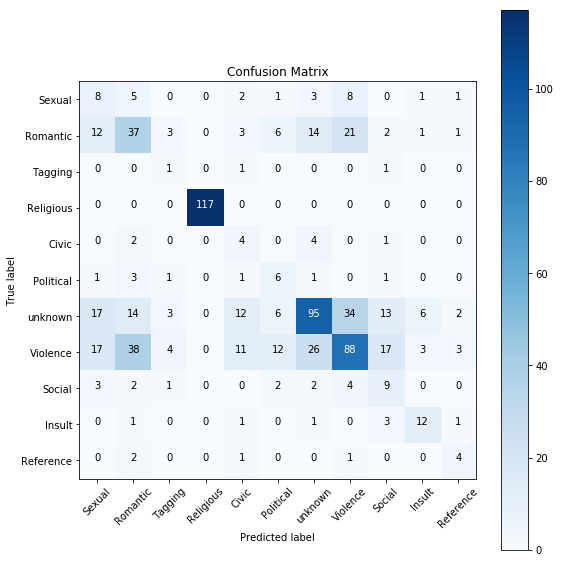

In [28]:
#Draw a figure
fig = plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_train, classes = class_names)

In [28]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

             precision    recall  f1-score   support

     Sexual       0.25      0.12      0.16        58
  Reference       0.37      0.36      0.36       104
   Romantic       0.33      0.08      0.12        13
   Violence       1.00      1.00      1.00       117
  Religious       0.36      0.11      0.17        36
    Tagging       0.43      0.18      0.26        33
    unknown       0.47      0.65      0.55       146
     Insult       0.40      0.56      0.47       156
  Political       0.39      0.19      0.26        47
      Civic       0.63      0.52      0.57        23
     Social       0.50      0.33      0.40        12

avg / total       0.50      0.51      0.49       745



Discuss

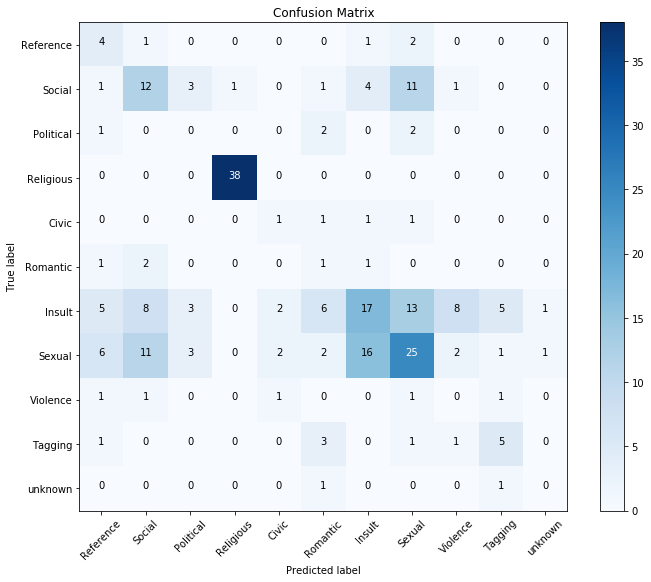

In [28]:
plt.figure(figsize = (10,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_test, classes = class_names)

In [29]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

              precision    recall  f1-score   support

   Reference       0.50      0.20      0.29        20
      Social       0.35      0.34      0.35        35
   Political       0.00      0.00      0.00         9
   Religious       1.00      0.97      0.99        39
       Civic       0.25      0.17      0.20         6
    Romantic       0.20      0.06      0.09        17
      Insult       0.25      0.42      0.31        40
      Sexual       0.36      0.45      0.40        56
    Violence       0.00      0.00      0.00        12
     Tagging       0.45      0.38      0.42        13
     unknown       0.00      0.00      0.00         2

   micro avg       0.41      0.41      0.41       249
   macro avg       0.31      0.27      0.28       249
weighted avg       0.41      0.41      0.40       249



This model is almost useless! It only classifies 'Reference', 'Insult', and 'Violence.'
There is wide variation in its predictive ability from class to class.

<a id = 'detour_cat'></a>

### Detour: improving the categories

I'm unhappy with the categories and think I can do better.

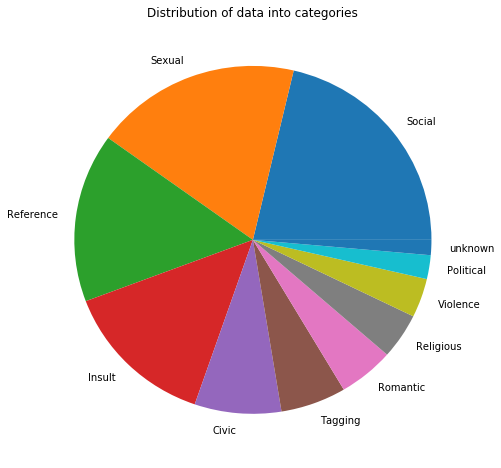

In [26]:
#COLROS ARE BROKEN
cat_counts = df_raw['Category'].value_counts()
#colors_for_orig_cats = ['lavender', 'brown', 'yellow', 'blue', 'lightblue', 'purple',
#                       'maroon', 'red', 'pink', 'darkblue', 'gray']
fig = plt.figure(figsize = (8,8))
plt.pie(x = cat_counts, labels = cat_counts.index)
plt.title('Distribution of data into categories')
plt.show()

There are two problems to solve:

 1. Categories are imprecise. (What isn't "social"?)
 2. Data is unevenly distributed into these categories

Before I try to up- or down-sample I'd like to see if I can rearrange the data within the categories. I've browsed the English translations of the graffiti and have spotted some key words that I want to count the incidence of across the categories. This may suggest some more precise categories for the data. It may also allow for more even data distribution across categories.

In [25]:
#A new df for the reorganized categories
df_clean = copy.deepcopy(df_raw)

In [26]:
#A lambda function with the "globals" so I don't have to pass them in every time
pysqldf = lambda q: sqldf(q, globals())

categories = list(df_raw['Category'].unique())

#Some possible new categories
#Hoping to draw values out from 'Social'
love = ['the girls', 'love', 'venus']
slave = ['servant', 'serve', 'slave']
emperor = ['Caesar', 'emperor', 'Nero']
gods = ['Jupiter', 'god', 'holy', 'pray']
greeting = ['bye', 'hello', 'goodbye', 'greetings']
glory = ['fight', 'mars','soldier', 'victor']
########## WARNING!! NSFW ################
lewd = ['bugger', 'cock', 'cunt', 'faggot', 'fuck', 'suck']
###########################################
blessing = ['best wishes', 'bravo',  'favor', 'favour', 'good luck', 'happy', 'smile']
curse = ['anger', 'beware', 'curse']
keyword_cats = [love, slave, emperor, gods, greeting, glory, lewd, blessing, curse]

#A list of all keywords
keywords = []
for cat in keyword_cats:
    for word in cat:
        keywords.append(word)
        
#Build a 'keyword matrix' with my custom function
#to show incidence of the above keywords in the 
#original categories of the data.
keywords_df = keyword_matrix(pysqldf, categories, keywords)

In [36]:
keywords_df

,Key_Word,Religious,Civic,Insult,Reference,Tagging,Social,Sexual,Romantic,unknown,Political,Violence
0,the girls,0,0,0,0,4,0,1,0,0,0,1
1,love,3,0,2,18,0,0,2,40,0,0,0
2,venus,12,0,0,5,1,1,2,0,0,0,1
3,servant,0,0,1,0,0,1,0,0,0,0,0
4,serve,0,4,0,1,0,0,0,0,0,0,0
5,slave,2,2,4,0,3,5,7,1,0,1,0
6,Caesar,0,1,1,0,0,0,0,0,0,3,2
7,emperor,1,0,0,0,1,0,0,0,0,3,0
8,Nero,1,0,1,0,1,2,1,0,0,5,5
9,Jupiter,0,0,1,0,0,1,0,0,0,0,0


In [32]:
#Opportunity to knock off many of the values from 'Social.'
keywords_df['Social'].sum()

139

In [27]:
#Categorize greetings, blessings, and curses as Hails 
#Hello, goodbye, good luck, go to hell)
hails = []
for words in [greeting, blessing, curse]:
    for word in words:
        hails.append(word)
write(df_clean, hails, 'In English', 'Category', 'Hail')

#Categorize references to emperors or slaves as Political
poli = []
for words in [emperor, slave]:
    for word in words:
        poli.append(word)
write(df_clean, poli, 'In English', 'Category', 'Political')

#Categorize glory words as Violence
write(df_clean, glory, 'In English', 'Category', 'Violence')
#Categorize lewd words as Lewd (new category)
write(df_clean, lewd, 'In English', 'Category', 'Lewd')
#Categorize love words as Romantic
write(df_clean, love, 'In English', 'Category', 'Romantic')
#Categorize gods words as Religious
write(df_clean, gods, 'In English', 'Category', 'Religious')

#Now:
#Combine 'Violence' and 'Political' into 'Glory'
write(df_clean, ['Violence', 'Political'], 'Category', 'Category', 'Glory')
#Combine 'Sexual' and 'Romantic' into 'Love'
write(df_clean, ['Sexual', 'Romantic'], 'Category', 'Category', 'Love')
#Combine 'unknown' and 'Tagging' into 'Civic'
write(df_clean, ['unknown', 'Tagging'], 'Category', 'Category', 'Civic')
#Combine 'Insult' with 'Hail' (They're both direct adresses)
write(df_clean, ['Insult'], 'Category', 'Category', 'Hail')
#Combine 'Religious' with 'Glory' (Politics, War, and Religion are all heady)
write(df_clean, ['Religious'], 'Category', 'Category', 'Glory')

#Now:
#Give the final categories jazzier names
replacements = {'Reference': 'Literature',
                'Social': 'Gossip',
                'Civic': 'Bulletin',
                'Religion': 'Gods'
                }
df_clean['Category'] = df_clean['Category'].replace(replacements)

How did all this work affect our categories?

In [ ]:
#FOR RTESTING
#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
#fracs = [15, 30, 45, 10]

#fig = plt.figure()

#ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
#ax1.pie(fracs, labels=labels, radius = 1.2)
#ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
#ax2.pie(fracs, labels=labels, radius = 1.2)
#plt.show()

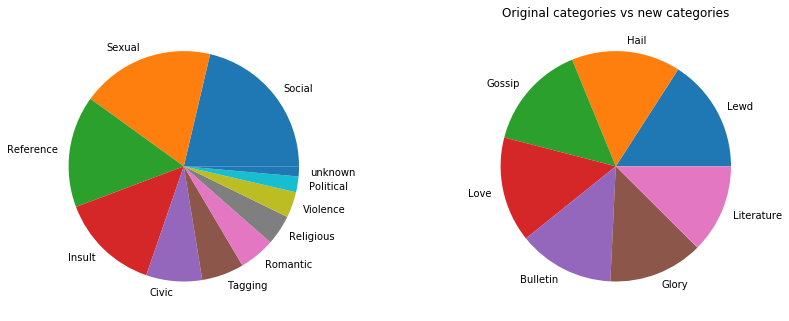

In [34]:
cat_counts = df_raw['Category'].value_counts()

#Colors for new categories
colors_for_new_cats = ['green', 'yellow', 'purple', 'gray', 'blue', 'red', 'brown']

#Values of old categories to count
cat_counts = df_raw['Category'].value_counts()
#Capture the values of the new categories to plot
v2cat_counts = df_clean['Category'].value_counts()

#Plot old categories side by side with new ones
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_axes([0, 0, .5, .5], aspect = 1)
ax1.pie(x = cat_counts, labels = cat_counts.index)
ax2 = fig.add_axes([0.5, 0, .5, .5], aspect = 1)
ax2.pie(x = v2cat_counts, labels = v2cat_counts.index)
#Need to fix title position
plt.title('Original categories vs new categories')
plt.show()

### MAKE THE COLORS CORRESPOND
Lavender   'Sexual', 'Love'
Brown   'Reference', 'Literature'
Yellow     'Insult', 'Hail'
Blue       'Civic', 'Bulletin'
Light blue 'Tagging', 'Bulletin'
Purple    'Romantic', 'Love'
Maroon    'Religious', 'Glory'
Red       'Violence', 'Glory'
Pink     'Political', 'Glory'
Dark blue  'unknown'], 'Bulletin'
Gray .      Social .     Gossip

Lewd  Green
Hail Yellow
Love Purple
Gossip Gray
Bulletin Blue
Glory Red
Literature Brown

In [ ]:
df_clean['Category'].value_counts()

Much better!

*Lewd*: Swear words and body parts

*Hail*: Hello, goodbye, bless you, curse you

*Love*: Romance & sex

*Gossip*: Have you heard who was drinking wine with Euphabia?

*Bulletin*: I baked bread today; I sold some pots today

*Glory*: The slaves won the battle! The emperor won the battle! The gods helped us win the battle!

*Literature*: Ovid, Aenid, Homer, Horace: we've got all the classics

Now let's see how this data performs with a plain vanilla logistic regression model.

<a id = 'model1'></a>

[(Back to top)](#top)

# Model #1: Logistic regression
### Prepare the data

In [32]:
df = copy.deepcopy(df_clean)

#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')

#Continuous data: 'Reggio', 'Insula', 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')

X = df.drop(['CIL IV #', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

### Build a model

#Build a logistic regression model
first_lr = LogisticRegression(fit_intercept=False, C=1e16)
#Fit the classifier to the training data
first_lr.fit(X_train, y_train)
#Generate predicted y values for training set
first_lr_y_hat_train = first_lr.predict(X_train)
#Generate predicted y values for testing set
first_lr_y_hat_test = first_lr.predict(X_test)

#Create a confusion matrix for the training set
first_lr_conf_matrix_train = confusion_matrix(first_lr_y_hat_train, y_train)
#Create a confusion matrix for the testing set
first_lr_conf_matrix_test = confusion_matrix(first_lr_y_hat_test, y_test)

#Create labels for the classes in the conf matrix
class_names = set(y)
#Draw a figure
#plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(first_lr_conf_matrix_train, title = 'Training set', classes = class_names)

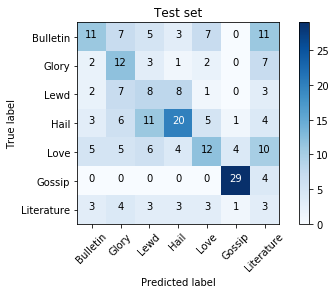

In [35]:
#plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(first_lr_conf_matrix_test, title = 'Test set', classes = class_names)

In [36]:
print('First model training set:')
print(classification_report(y_train, first_lr_y_hat_train, target_names = class_names))
print('First model testing set:')
print(classification_report(y_test, first_lr_y_hat_test, target_names = class_names))

First model training set:
              precision    recall  f1-score   support

    Bulletin       0.34      0.50      0.40       108
       Glory       0.54      0.44      0.48        91
        Lewd       0.40      0.27      0.32       111
        Hail       0.43      0.47      0.45       113
        Love       0.54      0.48      0.51       128
      Gossip       0.79      0.99      0.88        89
  Literature       0.39      0.32      0.35       105

   micro avg       0.48      0.48      0.48       745
   macro avg       0.49      0.50      0.49       745
weighted avg       0.48      0.48      0.48       745

First model testing set:
              precision    recall  f1-score   support

    Bulletin       0.25      0.42      0.31        26
       Glory       0.44      0.29      0.35        41
        Lewd       0.28      0.22      0.25        36
        Hail       0.40      0.51      0.45        39
        Love       0.26      0.40      0.32        30
      Gossip       0.88    

The first model could only classify 3 out of 11 categories. The second model can classify all 7 of its categories, and it does a good job on 4 out of 7 although its mean scores a bit lower than the first. There is less variation in predictive ability from column to column, a step toward a better model.

Maybe we can hone the model by adjusting a few of its parameters?

<a id = 'logreg_regparam'></a>

[(Back to top)](#top)

## Logistic regression: adjusting the regularization parameter

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/ssr

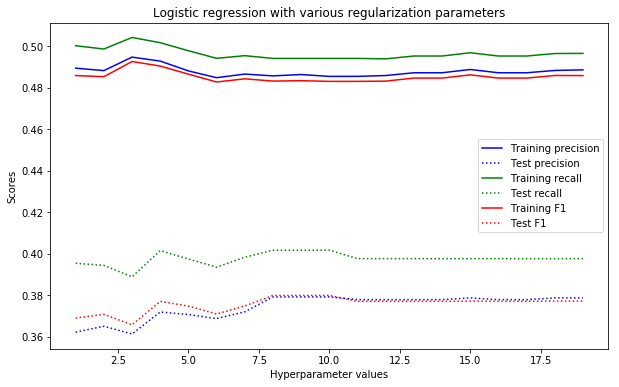

In [40]:
#A range of regularization parameters to try
params = np.arange(1, 20, 1)

#Build a df to hold the scores for each iteration
#Set up columns for a new df to hold scores
score_columns = ['param_values', 'prec_train', 'prec_test', 
                     'recall_train', 'recall_test', 'f1_train', 'f1_test']
    
#Instantiate adf to use for storing scores
lr_scores_df = pd.DataFrame(columns = score_columns)

#Run a model for each parameter and record
#its scores in the df
for param in params:
    #Build a logistic regression model
    lr = LogisticRegression(fit_intercept = True, C = param)
    #Fit the classifier to the training data
    lr.fit(X_train, y_train)
    #Generate predicted y values for training set
    lr_y_hat_train = lr.predict(X_train)
    #Generate predicted y values for testing set
    lr_y_hat_test = lr.predict(X_test)
    
    #Get the scores
    prec_train = precision_score(y_train, lr_y_hat_train, average = None).mean()
    prec_test = precision_score(y_test, lr_y_hat_test, average = None).mean()
    recall_train = recall_score(y_train, lr_y_hat_train, average = None).mean()
    recall_test =  recall_score(y_test, lr_y_hat_test, average = None).mean()
    f1_train = f1_score(y_train, lr_y_hat_train, average = None).mean()
    f1_test = f1_score(y_test, lr_y_hat_test, average = None).mean()
    
    #Write the scores to the df
    lr_scores_df = lr_scores_df.append({'param_values': param,
               'prec_train': prec_train,
               'prec_test': prec_test,
               'recall_train': recall_train,
               'recall_test': recall_test,
               'f1_train': f1_train,
               'f1_test': f1_test              
              }, ignore_index = True)
    
#Visualize all attempts together
plot_hypers(lr_scores_df, 'Logistic regression with various regularization parameters')

In [41]:
lr_scores_df.head(8)

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,1.0,0.489348,0.362278,0.500148,0.395449,0.485794,0.369075
1,2.0,0.488170,0.365125,0.498557,0.394406,0.485234,0.370836
2,3.0,0.494664,0.361401,0.504122,0.388912,0.492536,0.365810
3,4.0,0.492749,0.371979,0.501594,0.401554,0.490365,0.377090
4,5.0,0.488027,0.370737,0.497743,0.397472,0.486459,0.374813
5,6.0,0.484766,0.368817,0.494075,0.393569,0.482683,0.371015
6,7.0,0.486506,0.372064,0.495362,0.398331,0.484208,0.374876
7,8.0,0.485630,0.379248,0.494040,0.401732,0.483128,0.379966


*Observations*: The scores for the test sets all peak at a regularization parameter of 8 but again really risen above the scores of the earlier models.

<a id = 'logreg_cv'></a>

[(Back to top)](#top)

## Logistic regression: cross validation

In [ ]:
#>> clf = LogisticRegressionCV(cv=5, random_state=0,
#...                            multi_class='multinomial').fit(X, y)

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ssrosa/anacond

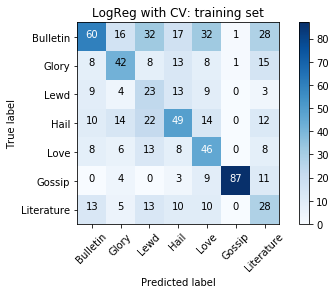

In [42]:
#Fit the training data to a logistic regression classifier with cross validation
#class weight 'balanced' allowed it to classify one more class
lrcv = LogisticRegressionCV(class_weight = 'balanced', 
                            multi_class = 'multinomial'
                           ).fit(X_train, y_train)

#Predict y values for training and test sets
lrcv_y_hat_train = lrcv.predict(X_train)
lrcv_y_hat_test = lrcv.predict(X_test)

#Create a confusion matrix for the training set
lrcv_conf_matrix_train = confusion_matrix(lrcv_y_hat_train, y_train)
#Create a confusion matrix for the test set
lrcv_conf_matrix_test = confusion_matrix(lrcv_y_hat_test, y_test)

#Draw a confusion matrix for the training set
plot_conf_matrix(lrcv_conf_matrix_train, title = 'LogReg with CV: training set', classes = class_names)

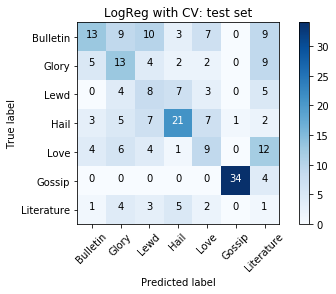

In [43]:
#Draw a confusion matrix for the test set
plot_conf_matrix(lrcv_conf_matrix_test, title = 'LogReg with CV: test set', classes = class_names)

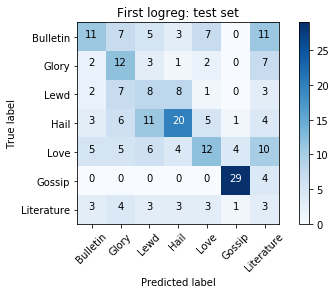

In [44]:
#Compare to plain vanilla logreg
plot_conf_matrix(first_lr_conf_matrix_test, title = 'First logreg: test set', classes = class_names)

In [45]:
print('LogReg with CV, training set:')
print(classification_report(y_train, lrcv_y_hat_train, target_names = class_names))
print('LogReg with CV, testing set:')
print(classification_report(y_test, lrcv_y_hat_test, target_names = class_names))

LogReg with CV, training set:
              precision    recall  f1-score   support

    Bulletin       0.32      0.56      0.41       108
       Glory       0.44      0.46      0.45        91
        Lewd       0.38      0.21      0.27       111
        Hail       0.40      0.43      0.42       113
        Love       0.52      0.36      0.42       128
      Gossip       0.76      0.98      0.86        89
  Literature       0.35      0.27      0.30       105

   micro avg       0.45      0.45      0.45       745
   macro avg       0.45      0.47      0.45       745
weighted avg       0.45      0.45      0.44       745

LogReg with CV, testing set:
              precision    recall  f1-score   support

    Bulletin       0.25      0.50      0.34        26
       Glory       0.37      0.32      0.34        41
        Lewd       0.30      0.22      0.25        36
        Hail       0.46      0.54      0.49        39
        Love       0.25      0.30      0.27        30
      Gossip       

In [46]:
#lrcv.n_iter_

*Observations*: The model with cross validation does not perform any better than the original logistic regression.

<a id = 'logreg_final'></a>

## The final logistic regression model

<a id = 'model2'></a>

[(Back to top)](#top)

# Model #2: Decision tree

In [30]:
df = copy.deepcopy(df_clean)

Preparing the data:

In [31]:
class_names = set(df['Category'])

# Create label encoder instance
lb = LabelEncoder() 

# Create Numerical labels for categorical columns
df['Literacy_'] = lb.fit_transform(df['Literacy'])
df['Position_'] = lb.fit_transform(df['Position'])
df['Build_Type_'] = lb.fit_transform(df['Building Type'])
df['Famous_'] = lb.fit_transform(df['Famous House'])
df['Writer_'] = lb.fit_transform(df['Writer'])
df['Econ_Status_'] = lb.fit_transform(df['Socio-economic status'])
df['Imperative_'] = lb.fit_transform(df['Imperative'])
#the target
df['Category_'] = lb.fit_transform(df['Category'])

columns_to_encode = ['Literacy_', 'Position_', 'Build_Type_', 
                     'Famous_', 'Writer_', 'Econ_Status_', 
                     'Imperative_'
                    ]

columns_continuous = ['Reggio', 'Insula', 'Flohr Score', 
                      'Characters'
                     ]

# Split features and target variable
#X = df[columns_to_encode,]
y = df['Category_']

# Instantiate a one hot encoder
enc = OneHotEncoder()

# Fit the feature set X
enc.fit(df[columns_to_encode])

# Transform X's encoded columns to onehot array 
onehotX = enc.transform(df[columns_to_encode])

#Convert the sparse matrix back into a DF
X_onehot = pd.DataFrame(onehotX.todense())
#Get just the continuous columns
continuous = df[columns_continuous]
#Have to reset the index so the rows will line up with
#the rows in the encoded set
continuous.reset_index(inplace = True)
continuous.drop(['index'], axis = 1, inplace = True)

#Bring back together the encoded columns and the continuous columns
X = pd.concat([X_onehot, continuous], axis = 1)

# Create a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## A plain vanilla decision tree

In [49]:
# Train the classifier and make predictions
first_tree = DecisionTreeClassifier(criterion = 'entropy')
first_tree.fit(X_train,y_train) 
y_hat_train = first_tree.predict(X_train)
y_hat_test = first_tree.predict(X_test)

### Visualize the result

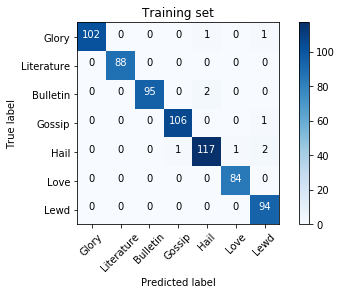

In [89]:
#Create confusion matrices with the results

class_names = set(df['Category'])

#A CM for the training set
first_tree_conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#A CM for the test set
first_tree_conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Draw the training CM
plot_conf_matrix(first_tree_conf_matrix_train, title = 'Training set', classes = class_names)

In [90]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

             precision    recall  f1-score   support

      Glory       0.98      1.00      0.99       102
 Literature       1.00      1.00      1.00        88
   Bulletin       0.98      1.00      0.99        95
     Gossip       0.99      0.99      0.99       107
       Hail       0.97      0.97      0.97       120
       Love       1.00      0.99      0.99        85
       Lewd       1.00      0.96      0.98        98

avg / total       0.99      0.99      0.99       695



Very over-fitted!

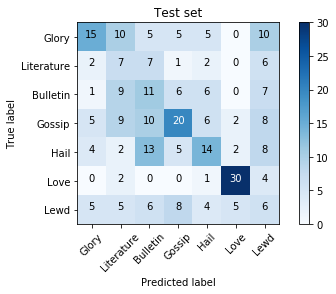

In [91]:
#Draw the test CM
plot_conf_matrix(first_tree_conf_matrix_test, title = 'Test set', classes = class_names)

In [51]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

             precision    recall  f1-score   support

      Glory       0.29      0.44      0.35        32
 Literature       0.22      0.14      0.17        44
   Bulletin       0.23      0.19      0.21        52
     Gossip       0.36      0.47      0.40        45
       Hail       0.32      0.37      0.34        38
       Love       0.82      0.79      0.81        39
       Lewd       0.21      0.16      0.18        49

avg / total       0.34      0.35      0.34       299



In [ ]:
#Image = draw_graph(clf)

In looking at the graph I notice that X_54, 'Characters' appears again and again.

### What about the cross validation score?

In [50]:
plain_cv_score = cross_val_score(first_tree, X, y, cv=3)
mean_plain_cv_score = np.mean(plain_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_plain_cv_score * 100))

Mean Cross Validation Score: 27.77%


In [54]:
#MAybe useful for interpreting graph
print('Features:', clf.n_features_)
print('Tree depth:', clf.tree_.max_depth)
print('Nodes and leaves:', clf.tree_.node_count)
print('"Capacity":', clf.tree_.capacity)

Features: 55
Tree depth: 21
Nodes and leaves: 735
"Capacity": 735


Accuracy is lower than plain vanilla logistic regression. 

Decision tree is very complex.

Needs hyperparameter tuning.

What about with the gini coefficient instead?

Has just slightly lower accuracy scores and 10 fewer nodes than when measuring entropy.

<a id = 'tree_tuning_hypers'></a>

[(Back to top)](#top)

## Decision tree: tuning hyperparameters

### Compare information-loss criterion

In [51]:
# Train the classifier and make predictions
clf = DecisionTreeClassifier(criterion = 'gini')
clf.fit(X_train,y_train) 
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

class_names = set(df['Category'])

#A CM for the training set
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#A CM for the test set
conf_matrix_test = confusion_matrix(y_hat_test, y_test)
plain_train_report = classification_report(y_train, y_hat_train, target_names = class_names)
plain_test_report = classification_report(y_test, y_hat_test, target_names = class_names)
print('Training set:')
print(plain_train_report)
print('Test set:')
print(plain_test_report)

Training set:
              precision    recall  f1-score   support

    Bulletin       0.98      1.00      0.99       102
       Glory       1.00      1.00      1.00        88
        Lewd       0.98      1.00      0.99        95
        Hail       0.99      0.99      0.99       107
        Love       0.97      0.97      0.97       120
      Gossip       1.00      0.99      0.99        85
  Literature       1.00      0.96      0.98        98

   micro avg       0.99      0.99      0.99       695
   macro avg       0.99      0.99      0.99       695
weighted avg       0.99      0.99      0.99       695

Test set:
              precision    recall  f1-score   support

    Bulletin       0.31      0.41      0.35        32
       Glory       0.28      0.23      0.25        44
        Lewd       0.18      0.17      0.17        52
        Hail       0.36      0.42      0.39        45
        Love       0.21      0.26      0.23        38
      Gossip       0.82      0.69      0.75        39


Even lower than the model with the entropy coefficient.

In [52]:
print('Features:', clf.n_features_)
print('Tree depth:', clf.tree_.max_depth)
print('Nodes and leaves:', clf.tree_.node_count)
print('"Capacity":', clf.tree_.capacity)

Features: 55
Tree depth: 22
Nodes and leaves: 727
"Capacity": 727


Let's tun some of these other parameters.

### Compare values of max_depth

In [53]:
print('Max depth of original tree:', clf.tree_.max_depth)

Max depth of original tree: 22


/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


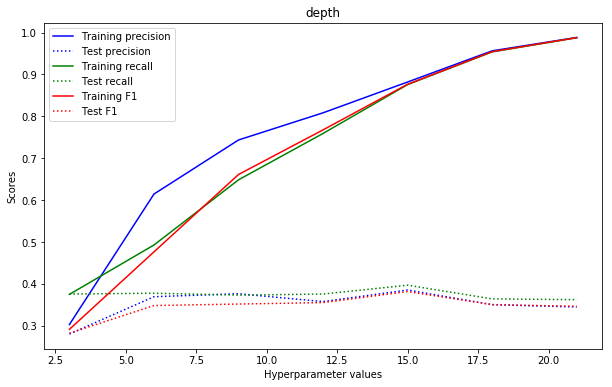

In [54]:
#Set values of chosen hyperparameter
depth_params = np.arange(3, 22, 3)
#Run model for each param value and store scores
depth_df = compare_hypers(depth_params, 'depth', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(depth_df, 'depth')

In [55]:
depth_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,3.0,0.302982,0.280303,0.374851,0.375712,0.291390,0.282083
1,6.0,0.614380,0.369267,0.492796,0.377594,0.476358,0.348193
2,9.0,0.743527,0.376367,0.648333,0.373079,0.661109,0.351752
3,12.0,0.808358,0.357606,0.759089,0.375642,0.767652,0.355249
4,15.0,0.881937,0.385290,0.875748,0.396781,0.876596,0.381563
5,18.0,0.956349,0.350225,0.953852,0.364123,0.954368,0.350445
6,21.0,0.988250,0.344728,0.987582,0.362147,0.987819,0.346394


Test set peaks at a depth of 15. (But only a very slight peak.)

### Compare values of min_samples_split

In [56]:
print('Min sample split of original tree:', 2 )

Min sample split of original tree: 2


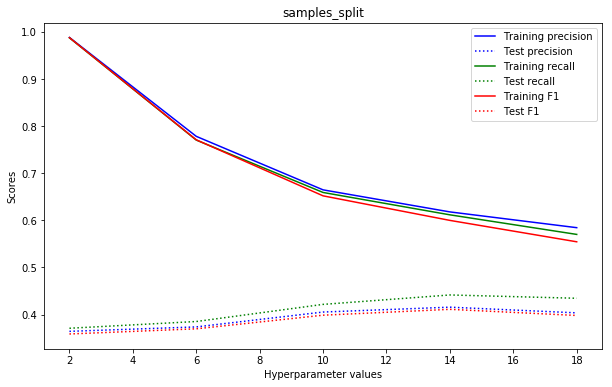

In [57]:
#Set values of chosen hyperparameter
samples_split_params = np.arange(2, 20, 4)
#Run model for each param value and store scores
samples_split_df = compare_hypers(samples_split_params, 'samples_split', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(samples_split_df, 'samples_split')

In [44]:
samples_split_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,2.0,0.988250,0.338616,0.987582,0.360219,0.987819,0.340997
1,4.0,0.862982,0.371737,0.860074,0.388822,0.858197,0.371302
2,6.0,0.780057,0.388133,0.771995,0.397033,0.771845,0.381539
3,8.0,0.724944,0.390761,0.710846,0.398797,0.707856,0.379502
4,10.0,0.666627,0.405133,0.660669,0.421564,0.654478,0.398824
5,12.0,0.628235,0.416408,0.620344,0.442070,0.608602,0.409847
6,14.0,0.619834,0.419035,0.612681,0.444804,0.600638,0.414121
7,16.0,0.607261,0.410985,0.595347,0.438810,0.579780,0.406754
8,18.0,0.584427,0.403562,0.570118,0.434546,0.554446,0.398038


14 minimum samples to split

### Compare values of min_samples_leaf

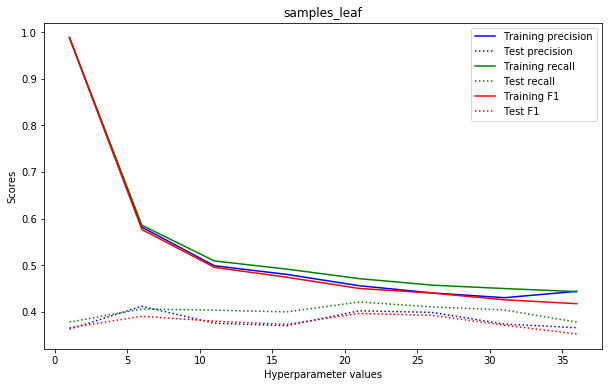

In [58]:
#Set values of chosen hyperparameter
samples_leaf_params = np.arange(1, 40, 5)
#Run model for each param value and store scores
samples_leaf_df = compare_hypers(samples_leaf_params, 'samples_leaf', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(samples_leaf_df, 'samples_leaf')

*Observations*: The test set seems to reach a peak at 6 samples per leaf.

### Compare values of max_features

In [59]:
print('Features in the original tree:', clf.n_features_)

Features in the original tree: 55


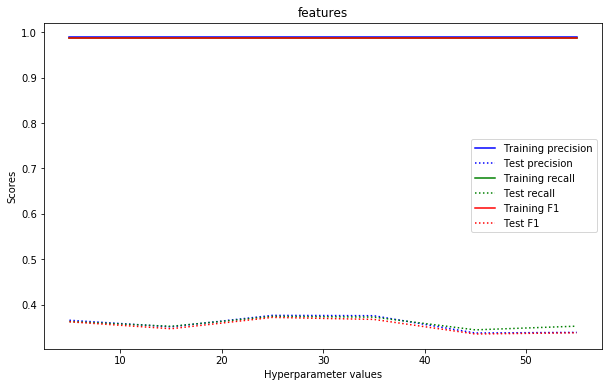

In [60]:
#Set values of chosen hyperparameter
feature_params = np.arange(5, 65, 10)
#Run model for each param value and store scores
feature_df = compare_hypers(feature_params, 'features', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(feature_df, 'features')

In [55]:
feature_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,5.0,0.98825,0.390014,0.987582,0.384861,0.987819,0.383297
1,15.0,0.98825,0.340477,0.987582,0.335394,0.987819,0.334314
2,25.0,0.98825,0.357527,0.987582,0.361711,0.987819,0.357852
3,35.0,0.98825,0.342921,0.987582,0.356537,0.987819,0.342394
4,45.0,0.98825,0.322142,0.987582,0.338374,0.987819,0.326596
5,55.0,0.98825,0.327529,0.987582,0.342351,0.987819,0.328718


*Observations*: Scores are highest when there are only 15 features. But they're only slightly higher. At this point I don't know which features are being selected. I'd hope it were the ones at the top of the tree.

### Compare values of max_leaf_nodes

In [61]:
print('Nodes and leaves in original tree:', clf.tree_.node_count)

Nodes and leaves in original tree: 727


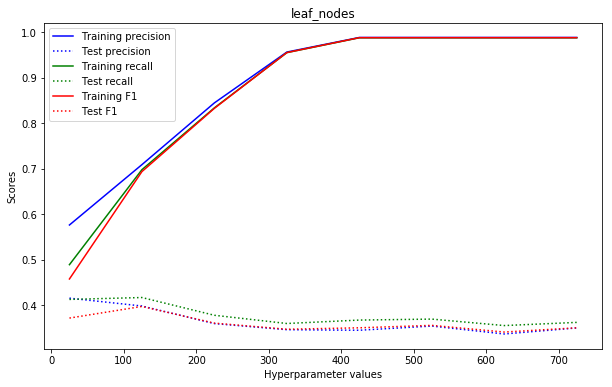

In [62]:
#Set values of chosen hyperparameter
leaf_nodes_params = np.arange(25, 800, 100)
#Run model for each param value and store scores
leaf_nodes_df = compare_hypers(leaf_nodes_params, 'leaf_nodes', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(leaf_nodes_df, 'leaf_nodes')

In [60]:
leaf_nodes_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,25.0,0.575957,0.415111,0.488729,0.412375,0.457281,0.371352
1,125.0,0.709131,0.384044,0.695475,0.402490,0.691680,0.383131
2,225.0,0.844061,0.346611,0.833554,0.365653,0.831933,0.349736
3,325.0,0.955666,0.329450,0.953181,0.337586,0.953489,0.327815
4,425.0,0.988250,0.335428,0.987582,0.346898,0.987819,0.336210
5,525.0,0.988250,0.356551,0.987582,0.373387,0.987819,0.357614
6,625.0,0.988250,0.365203,0.987582,0.381063,0.987819,0.365432
7,725.0,0.988250,0.363551,0.987582,0.376460,0.987819,0.363482


*Observations*: The test set gets the best results when the tree has about 125 leaves and nodes.

### Compare values of min_impurity_decrease

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

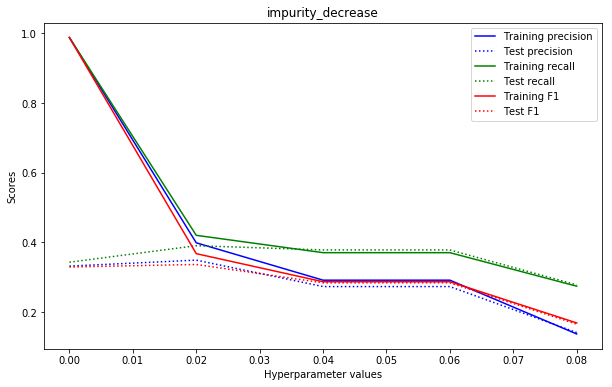

In [63]:
#Set values of chosen hyperparameter
impurity_decrease_params = np.arange(0, .1, .02)
#Run model for each param value and store scores
impurity_decrease_df = compare_hypers(impurity_decrease_params, 'impurity_decrease', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(impurity_decrease_df, 'impurity_decrease')

*Observations*: Test set does best at impurity decrease of 0.02.

### Hyperparameter tuning summary

- criterion: entropy
- max_depth: 12. (But only a very slight peak.)
- min_samples_split: 14
- min_samples_leaf: 6
- max_features: 15
- max_leaf_node: about 125
- min_impurity_decrease: 0.02

The most obvious conclusion is that the test set cannot break past 40% by any measure and with any individual hyperparameter tuned.

Perhaps a combination found with a GridSearch could get past 40%?

<a id = 'tree_grid_search'></a>

[(Back to top)](#top)

## Decision tree: tuning hyperparameters with GridSearchCV

In [70]:
#Instantiate a new tree
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': depth_params,
    'min_samples_split': samples_split_params,
    'min_samples_leaf': samples_leaf_params,
    'max_features': feature_params,
    'max_leaf_nodes': leaf_nodes_params,
    'min_impurity_decrease': impurity_decrease_params
    }

gs_tree = GridSearchCV(clf, param_grid, cv=3)

In [65]:
#K-Folds time criteria times the rest
3 * 2 * len(depth_params) * len(samples_split_params) * len(samples_leaf_params) * len(feature_params) * len(leaf_nodes_params) * len(impurity_decrease_params)

403200

In [71]:
start = time.time()
gs_tree.fit(X_train,  y_train)
end = time.time()
print(end - start)

1408.8745830059052


In [66]:
1462.7618942260742 / 60

24.379364903767904

In [67]:
1462.7618942260742 / 403200

0.003627881682108319

In [ ]:
24 minutes for 400,000 models. 0.003627881682108319 seconds per model.

In [78]:
tree_best_params = gs_tree.best_params_

In [79]:
tree_best_params

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 35,
 'max_leaf_nodes': 725,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 16,
 'min_samples_split': 14}

*Compare to visual inspection*

- criterion: entropy
- max_depth: 12. (But only a very slight peak.)
- max_features: 15
- max_leaf_node: about 125
- min_impurity_decrease: 0.02
- min_samples_leaf: 6
- min_samples_split: 14

In [74]:
#Don't know if I should use the training data or test data here.
#Should I scale the continuous columns?
gs_training_score = np.mean(gs_tree.cv_results_['mean_train_score'])
gs_testing_score = gs_tree.score(X, y)

print("Mean Training Score: {:.4}%".format(gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(gs_testing_score * 100))
#print("Best Parameter Combination Found During Grid Search:")
#gs_tree.best_params_

Mean Training Score: 31.9%
Mean Testing Score: 45.27%


C:\Users\Stee\Anaconda3good\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<a id = 'tree_final'></a>

[(Back to top)](#top)

## Decision tree: the final model

In [80]:
tree_best_params

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 35,
 'max_leaf_nodes': 725,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 16,
 'min_samples_split': 14}

I'm going to use 125 leaves/nodes as shown by my plot, not 725 as chosen by the grid search.

In [32]:
# Train the classifier and make predictions
final_tree = DecisionTreeClassifier(
                criterion = 'gini',
                max_depth = 12,
                max_features = 35,
                max_leaf_nodes = 125,
                min_impurity_decrease = 0.0,
                min_samples_leaf = 16,
                min_samples_split = 14
            )
final_tree.fit(X_train,y_train) 
final_tree_y_hat_train = final_tree.predict(X_train)
final_tree_y_hat_test = final_tree.predict(X_test)

class_names = set(df['Category'])

#A CM for the training set
final_tree_conf_matrix_train = confusion_matrix(final_tree_y_hat_train, y_train)
#A CM for the test set
final_tree_conf_matrix_test = confusion_matrix(final_tree_y_hat_test, y_test)

#Score reports
final_tree_train_report = classification_report(y_train, final_tree_y_hat_train, target_names = class_names)
final_tree_test_report = classification_report(y_test, final_tree_y_hat_test, target_names = class_names)
print('Training set:')
print(final_tree_train_report)
print('Test set:')
print(final_tree_test_report)

Training set:
              precision    recall  f1-score   support

        Hail       0.40      0.46      0.43       102
      Gossip       0.42      0.38      0.40        88
    Bulletin       0.38      0.28      0.33        95
        Lewd       0.45      0.56      0.50       107
       Glory       0.50      0.47      0.49       120
  Literature       0.77      0.99      0.87        85
        Love       0.36      0.27      0.30        98

   micro avg       0.48      0.48      0.48       695
   macro avg       0.47      0.49      0.47       695
weighted avg       0.46      0.48      0.47       695

Test set:
              precision    recall  f1-score   support

        Hail       0.17      0.22      0.19        32
      Gossip       0.38      0.27      0.32        44
    Bulletin       0.20      0.15      0.17        52
        Lewd       0.30      0.47      0.37        45
       Glory       0.38      0.42      0.40        38
  Literature       0.84      0.97      0.90        39


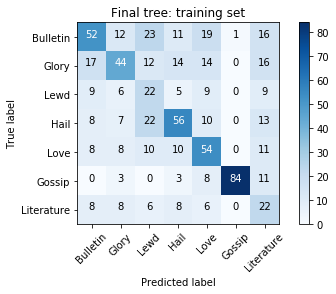

In [67]:
#with 125 leaves/nodes
plot_conf_matrix(final_tree_conf_matrix_train, title = 'Final tree: training set', classes = class_names)

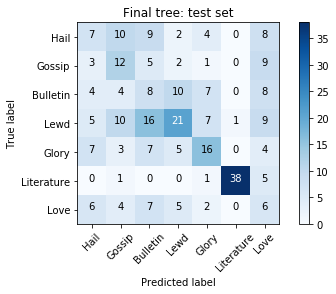

In [33]:
#with 125 leaves/nodes
plot_conf_matrix(final_tree_conf_matrix_test, title = 'Final tree: test set', classes = class_names)

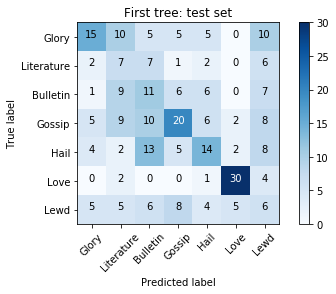

In [98]:
#Compare to first tree test set:
plot_conf_matrix(first_tree_conf_matrix_test, title = 'First tree: test set', classes = class_names)

### What about the cross validation score?

In [108]:
print('First model')
print('Mean accuracy: {:.4}%'.format(first_tree.score(X_test, y_test) * 100))
print("Mean cross validation score: {:.4}%".format(mean_plain_cv_score * 100))

First model
Mean accuracy: 34.45%
Mean cross validation score: 25.86%


In [69]:
final_tree_cv_score = cross_val_score(final_tree, X, y, cv=3)
mean_final_tree_cv_score = np.mean(final_tree_cv_score)
print('Final model')
print('Mean accuracy: {:.4}%'.format(final_tree.score(X_test, y_test) * 100))
print("Mean cross validation score: {:.4}%".format(mean_final_tree_cv_score * 100))

Final model
Mean accuracy: 36.79%
Mean cross validation score: 30.29%


In [35]:
#Visualize the tree
#draw_graph(final_tree)

### Interpretation

This model is slightly better than the un-tuned version but still isn't very good. 


#### Reality check: 

You'd have a 14% chance of getting the right category by random guessing, so it isn't impressive to just double that chance through a painstakingly constructed decision tree.

<a id = 'model3'></a>

[(Back to top)](#top)

# Model \#3

In [28]:
df = copy.deepcopy(df_clean)

#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')

#Continuous data: 'Reggio', 'Insula', 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')

#Build the feature set by dropping the uncategorized categorical columns
#and leaving the continuous ones
X = df.drop(['CIL IV #', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative'
            ], axis = 1)
#Add the new categorical columns
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25, random_state=12)

In [47]:
#Build a regular decision tree to start
rf_tree = DecisionTreeClassifier(criterion = "gini") 
rf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [48]:
print('Features:', rf_tree.n_features_)
print('Max depth:', rf_tree.tree_.max_depth)
print('Nodes and leaves:', rf_tree.tree_.node_count)
print('"Capacity":', rf_tree.tree_.capacity)

Features: 55
Max depth: 24
Nodes and leaves: 745
"Capacity": 745


In [55]:
rf_tree.feature_importances_.max()

0.2720348315546461

In [56]:
rf_tree_features_importances = dict(zip(X.columns, rf_tree.feature_importances_))

In [57]:
rf_tree_features_importances

{'Reggio': 0.06787162455121441,
 'Insula': 0.09577483424962491,
 'Flohr Score': 0.09579113551220664,
 'Characters': 0.2720348315546461,
 'Literacy_2': 0.02005481622163229,
 'Literacy_3': 0.023457262887606006,
 'Position_altar': 0.0,
 'Position_atrium': 0.010359165046011864,
 'Position_bath': 0.0,
 'Position_column': 0.006502554930625636,
 'Position_counter': 0.00239567813233576,
 'Position_dining room': 0.004152508762715318,
 'Position_entrance': 0.012131035055498148,
 'Position_facade': 0.009961874900415744,
 'Position_garden': 0.005968027078176051,
 'Position_kitchen': 0.002448915424165446,
 'Position_latrine': 0.003194237509781013,
 'Position_marble': 0.0,
 'Position_outer wall': 0.005913142056796995,
 'Position_peristyle': 0.02336701005411651,
 'Position_portico': 0.00181006792220924,
 'Position_room': 0.0,
 'Position_shop': 0.0,
 'Position_staircase': 0.0,
 'Position_tablinum': 0.0022359662568467095,
 'Position_unknown': 0.026652602155603312,
 'Position_workshop': 0.0,
 'Building_

In [ ]:

rf_tree_features_importances = dict(zip(X.shape, rf_tree.feature_importances_))

Text(0, 0.5, 'Feature')

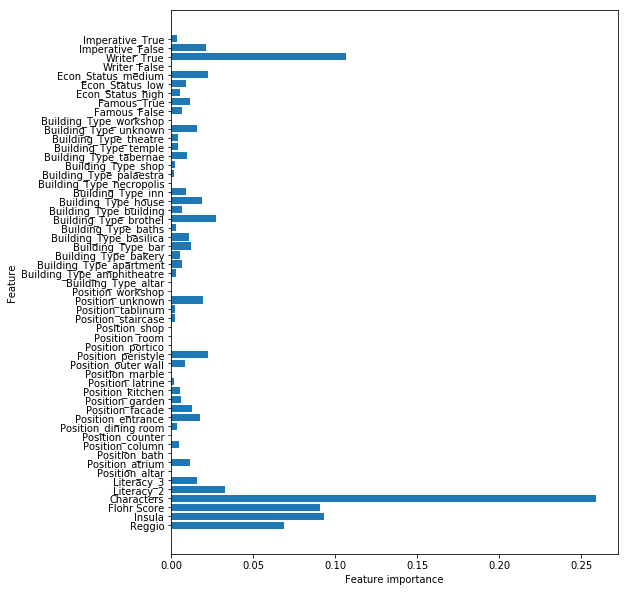

In [59]:
n_features = X_train.shape[1]
plt.figure(figsize=(8,10))
plt.barh(range(n_features), tree.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel("Feature importance")
plt.ylabel("Feature")

In [63]:
#Get predicted values for trainign set and test set
rf_tree_y_hat_train = rf_tree.predict(X_train)
rf_tree_y_hat_test = rf_tree.predict(X_test)
#Visualize and get scores
print('Tree trainig set')
print(confusion_matrix(y_train, rf_tree_y_hat_train))
print('Tree test set')
print(confusion_matrix(y_test, rf_tree_y_hat_test))

Tree trainig set
[[108   0   0   0   0   0   0]
 [  0  91   0   0   0   0   0]
 [  0   0 111   0   0   0   0]
 [  0   0   0 112   1   0   0]
 [  1   0   2   1 124   0   0]
 [  0   0   0   0   1  88   0]
 [  1   0   0   1   2   0 101]]
Tree test set
[[10  3  3  4  3  0  3]
 [ 6  7  7  6  5  0 10]
 [ 2  5 10  7  8  0  4]
 [ 6  3 10 11  3  0  6]
 [ 1  2  9  9  8  0  1]
 [ 0  1  0  2  5 21  6]
 [ 7  7  8  4  5  3  8]]


In [64]:
print('Tree trainig set')
print(classification_report(y_train, rf_tree_y_hat_train))
print('Tree test set')
print(classification_report(y_test, rf_tree_y_hat_test))

Tree trainig set
              precision    recall  f1-score   support

    Bulletin       0.98      1.00      0.99       108
       Glory       1.00      1.00      1.00        91
      Gossip       0.98      1.00      0.99       111
        Hail       0.98      0.99      0.99       113
        Lewd       0.97      0.97      0.97       128
  Literature       1.00      0.99      0.99        89
        Love       1.00      0.96      0.98       105

   micro avg       0.99      0.99      0.99       745
   macro avg       0.99      0.99      0.99       745
weighted avg       0.99      0.99      0.99       745

Tree test set
              precision    recall  f1-score   support

    Bulletin       0.31      0.38      0.34        26
       Glory       0.25      0.17      0.20        41
      Gossip       0.21      0.28      0.24        36
        Hail       0.26      0.28      0.27        39
        Lewd       0.22      0.27      0.24        30
  Literature       0.88      0.60      0.71    

<a id = 'forest_final'></a>

## The final random forest model

### Interpretation

<a id = 'model4'></a>

[(Back to top)](#top)

# Conclusions

In [ ]:
#df_raw[df_raw['In English'].str.contains('bake', regex = False, case = False)]
